# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pickle
import itertools
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

# b. MNIST Data Loader

In [9]:
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
		transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. Unconditional GAN**


# a. Training Function for Discriminator

In [10]:
criterion = nn.BCELoss()

def train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels):
    discriminator.zero_grad()
    if with_condition:
      outputs = discriminator(images, cls_labels)
    else:
      outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.view(-1, 1))
    real_score = outputs

    if with_condition:
      outputs = discriminator(fake_images, cls_labels)
    else:
      outputs = discriminator(fake_images)

    fake_loss = criterion(outputs, fake_labels.view(-1, 1))
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score, fake_loss

# b. Training Function for Generator

In [11]:
def train_generator(generator, g_optimizer, discriminator_outputs, real_labels, with_condition):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.view(-1, 1))
    g_loss_fake = criterion(discriminator_outputs, 1 - real_labels.view(-1, 1))
    g_loss.backward()
    g_optimizer.step()
    return g_loss, g_loss_fake

# c. Monitors for Images and Losses


In [12]:
def monitor_images(generator, test_noise, with_condition):
    num_test_samples = test_noise.shape[0]
    size_figure_grid = int(math.sqrt(num_test_samples))
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(4, 4))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)

    if with_condition:
      cls_labels = torch.randint(0, 10, (num_test_samples,)).to(device)
      test_images = generator(test_noise, label = cls_labels)
    else:
      test_images = generator(test_noise)

    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
        if with_condition:
            ax[i, j].set_title(f'Class: {cls_labels[k].item()}', fontsize=10)
    plt.show()


def monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake):
    def moving_average(x, win=100):
        return np.convolve(x, np.ones(win), 'same') / np.convolve(np.ones_like(x), np.ones(win), 'same')

    plt.figure(figsize=(8, 3))
    iters = np.arange(len(d_losses))
    epochs = iters * batch_size / 60000
    plt.plot(epochs, moving_average(d_losses), label='d_loss')
    plt.plot(epochs, moving_average(g_losses), label='g_loss')
    plt.plot(epochs, moving_average(d_losses_fake), label='d_loss_fake')
    plt.plot(epochs, moving_average(g_losses_fake), label='g_loss_fake')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


# c. Model for Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, channels=[512, 256, 128], with_condition=False):
        super().__init__()
        self.with_condition = with_condition
        self.model = None

        ##################
        ### Problem 1: Implement Discriminator
        ##################
        self.model = [
            nn.Linear(784, channels[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
        ]
        for i in range(len(channels) - 1):
            self.model += [
                nn.Linear(channels[i], channels[i + 1]),
                nn.LeakyReLU(),
                nn.Dropout(0.2),
            ]
        self.model += [nn.Linear(channels[-1], 1), nn.Sigmoid()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), 784)
        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return out


with torch.no_grad():
    discriminator = Discriminator(with_condition=False).to(device)
    for iter, (images, labels) in enumerate(test_loader):
        images = images.to(device)  # (128, 1, 28, 8)
        labels = labels.to(device)  # (128,)
        print(discriminator(images, labels).shape)
        break

torch.Size([128, 1])


# e. Model for Generator


In [14]:
class Generator(nn.Module):
    def __init__(self, dim_z=100, channels=[128, 256, 512], with_condition=False):
        super().__init__()
        self.dim_z = dim_z
        self.with_condition = with_condition

        self.model = None
        ##################
        ### Problem 1: Implement Generator
        ##################
        self.model = [nn.Linear(dim_z, channels[0]), nn.LeakyReLU()]
        for i in range(len(channels) - 1):
            self.model += [nn.Linear(channels[i], channels[i + 1]), nn.LeakyReLU()]
        self.model += [nn.Linear(channels[-1], 784), nn.Tanh()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), self.dim_z)

        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################

        out = self.model(x)
        return out


with torch.no_grad():
    generator = Generator(with_condition=False).to(device)
    noise = Variable(torch.randn(batch_size, generator.dim_z)).to(device)
    print(generator(noise).shape)

torch.Size([128, 784])


# d. Training

In [17]:
num_batches = len(train_loader)

def train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise,
                    num_epochs, d_freq, with_condition):
  d_losses = []
  g_losses = []
  d_losses_fake = []
  g_losses_fake = []
  dim_z = generator.dim_z
  for epoch in range(num_epochs):
      for n, (images, cls_labels) in enumerate(train_loader):
          images = Variable(images.to(device)) # (batch_size, 1, 28, 28)
          real_labels = Variable(torch.ones(images.size(0)).to(device)) # (batch_size, )
          cls_labels = cls_labels.to(device) # (batch_size, )

          for _ in range(10): 
            # Sample from generator
            noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)
            fake_images = generator(noise, label=cls_labels if with_condition else None) # (batch_size, 784)
            fake_labels = Variable(torch.zeros(images.size(0)).to(device)) # (batch_size, )

            # Train the discriminator
            d_loss, real_score, fake_score, d_loss_fake = train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels=cls_labels)

          if n % d_freq == 0:
            noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)

            # Sample again from the generator and get output from discriminator
            fake_images = generator(noise, label=cls_labels if with_condition else None)
            outputs = discriminator(fake_images, label=cls_labels if with_condition else None)

            # Train the generator
            g_loss, g_loss_fake = train_generator(generator, g_optimizer, outputs, real_labels, with_condition)



          d_losses.append(d_loss.data.detach().cpu().numpy())
          g_losses.append(g_loss.data.detach().cpu().numpy())
          d_losses_fake.append(d_loss_fake.data.detach().cpu().numpy())
          g_losses_fake.append(g_loss_fake.data.detach().cpu().numpy())

          if (n+1) % 100 == 0:
              print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, d_loss_fake: %.4f, g_loss: %.4f, g_loss_fake: %.4f, '
                    'D(x): %.2f, D(G(z)): %.2f'
                    %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data, d_loss_fake.data, g_loss.data, g_loss_fake.data,
                      real_score.data.mean(), fake_score.data.mean()))
      if epoch in [0, 19] or (epoch+1) % 50 == 0:
        torch.save(discriminator.state_dict(), f'/workspace/GAN_ablation3_disc_epoch={epoch+1}.pt')
        torch.save(generator.state_dict(), f'/workspace/GAN_ablation3_gen_epoch={epoch+1}.pt')

      if epoch == 0 or (epoch+1) % 5 == 0:
        monitor_images(generator, test_noise, with_condition=with_condition)
        monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)
  return d_losses, d_losses_fake, g_losses, g_losses_fake

In [ ]:
# set number of epochs and initialize figure counter
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)



In [ ]:
# I have pretrained 60 epochs. So the epochs of the results below are epoch + 60
num_epochs = 160
d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

# e. Ablation Study

Epoch [1/200], Step[100/469], d_loss: 0.0000, d_loss_fake: 0.0000, g_loss: 12.2659, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [1/200], Step[200/469], d_loss: 0.0002, d_loss_fake: 0.0002, g_loss: 13.2383, g_loss_fake: 0.0019, D(x): 1.00, D(G(z)): 0.00
Epoch [1/200], Step[300/469], d_loss: 0.0006, d_loss_fake: 0.0005, g_loss: 8.5947, g_loss_fake: 0.0007, D(x): 1.00, D(G(z)): 0.00
Epoch [1/200], Step[400/469], d_loss: 0.0029, d_loss_fake: 0.0029, g_loss: 6.6232, g_loss_fake: 0.0048, D(x): 1.00, D(G(z)): 0.00


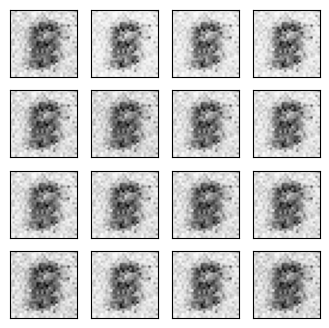

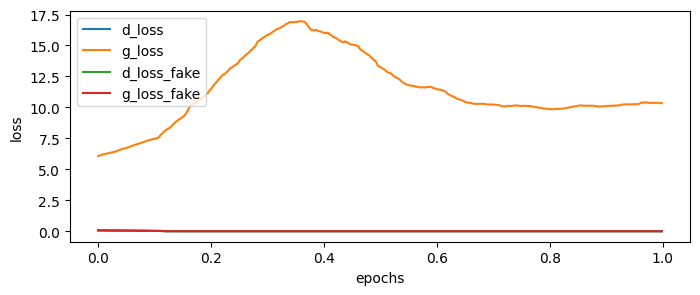

Epoch [2/200], Step[100/469], d_loss: 0.0001, d_loss_fake: 0.0000, g_loss: 11.3918, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [2/200], Step[200/469], d_loss: 0.0013, d_loss_fake: 0.0013, g_loss: 13.9814, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [2/200], Step[300/469], d_loss: 0.0000, d_loss_fake: 0.0000, g_loss: 12.6076, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [2/200], Step[400/469], d_loss: 0.0001, d_loss_fake: 0.0000, g_loss: 10.5164, g_loss_fake: 0.0001, D(x): 1.00, D(G(z)): 0.00
Epoch [3/200], Step[100/469], d_loss: 0.0000, d_loss_fake: 0.0000, g_loss: 14.3897, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [3/200], Step[200/469], d_loss: 0.0000, d_loss_fake: 0.0000, g_loss: 17.5631, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [3/200], Step[300/469], d_loss: 0.0000, d_loss_fake: 0.0000, g_loss: 13.9397, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [3/200], Step[400/469], d_loss: 0.0000, d_loss_fake: 0.0000, g_loss: 12.6054,

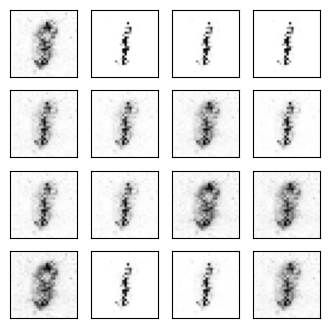

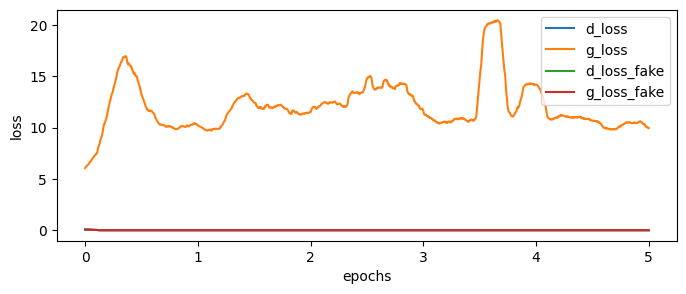

Epoch [6/200], Step[100/469], d_loss: 0.0002, d_loss_fake: 0.0001, g_loss: 12.1509, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [6/200], Step[200/469], d_loss: 0.0022, d_loss_fake: 0.0014, g_loss: 10.5551, g_loss_fake: 0.0001, D(x): 1.00, D(G(z)): 0.00
Epoch [6/200], Step[300/469], d_loss: 0.0018, d_loss_fake: 0.0002, g_loss: 8.0218, g_loss_fake: 0.0035, D(x): 1.00, D(G(z)): 0.00
Epoch [6/200], Step[400/469], d_loss: 0.0029, d_loss_fake: 0.0003, g_loss: 10.2599, g_loss_fake: 0.0009, D(x): 1.00, D(G(z)): 0.00
Epoch [7/200], Step[100/469], d_loss: 0.0092, d_loss_fake: 0.0002, g_loss: 9.1040, g_loss_fake: 0.0002, D(x): 0.99, D(G(z)): 0.00
Epoch [7/200], Step[200/469], d_loss: 0.0066, d_loss_fake: 0.0042, g_loss: 7.9024, g_loss_fake: 0.0018, D(x): 1.00, D(G(z)): 0.00
Epoch [7/200], Step[300/469], d_loss: 0.0023, d_loss_fake: 0.0007, g_loss: 7.7857, g_loss_fake: 0.0006, D(x): 1.00, D(G(z)): 0.00
Epoch [7/200], Step[400/469], d_loss: 0.0125, d_loss_fake: 0.0004, g_loss: 7.9278, g_lo

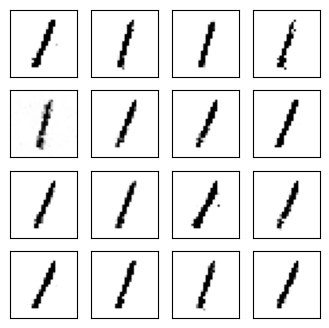

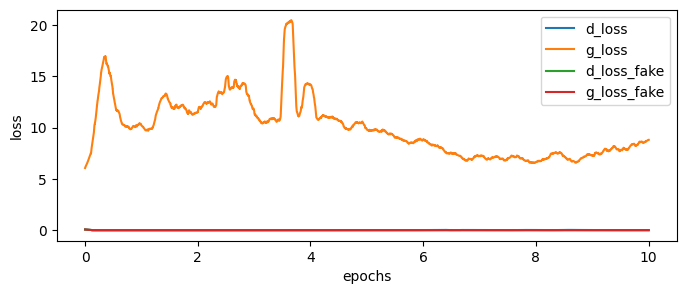

Epoch [11/200], Step[100/469], d_loss: 0.0034, d_loss_fake: 0.0034, g_loss: 6.9030, g_loss_fake: 0.0031, D(x): 1.00, D(G(z)): 0.00
Epoch [11/200], Step[200/469], d_loss: 0.0084, d_loss_fake: 0.0084, g_loss: 9.2619, g_loss_fake: 0.0035, D(x): 1.00, D(G(z)): 0.01
Epoch [11/200], Step[300/469], d_loss: 0.0330, d_loss_fake: 0.0063, g_loss: 6.1061, g_loss_fake: 0.0061, D(x): 0.99, D(G(z)): 0.01
Epoch [11/200], Step[400/469], d_loss: 0.0000, d_loss_fake: 0.0000, g_loss: 11.8002, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [12/200], Step[100/469], d_loss: 0.0036, d_loss_fake: 0.0011, g_loss: 9.1324, g_loss_fake: 0.0012, D(x): 1.00, D(G(z)): 0.00
Epoch [12/200], Step[200/469], d_loss: 0.0018, d_loss_fake: 0.0018, g_loss: 9.7329, g_loss_fake: 0.0021, D(x): 1.00, D(G(z)): 0.00
Epoch [12/200], Step[300/469], d_loss: 0.0139, d_loss_fake: 0.0067, g_loss: 8.7773, g_loss_fake: 0.0022, D(x): 0.99, D(G(z)): 0.01
Epoch [12/200], Step[400/469], d_loss: 0.0196, d_loss_fake: 0.0195, g_loss: 8.9131

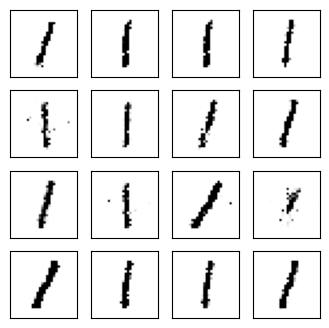

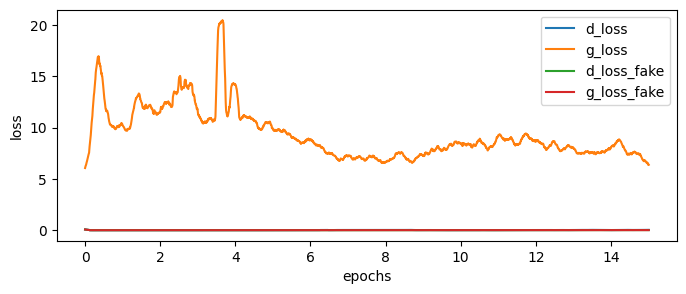

Epoch [16/200], Step[100/469], d_loss: 0.0133, d_loss_fake: 0.0023, g_loss: 8.1705, g_loss_fake: 0.0015, D(x): 0.99, D(G(z)): 0.00
Epoch [16/200], Step[200/469], d_loss: 0.0520, d_loss_fake: 0.0012, g_loss: 8.1842, g_loss_fake: 0.0010, D(x): 0.98, D(G(z)): 0.00
Epoch [16/200], Step[300/469], d_loss: 0.0247, d_loss_fake: 0.0138, g_loss: 7.1701, g_loss_fake: 0.0038, D(x): 0.99, D(G(z)): 0.01
Epoch [16/200], Step[400/469], d_loss: 0.0117, d_loss_fake: 0.0057, g_loss: 8.6950, g_loss_fake: 0.0033, D(x): 1.00, D(G(z)): 0.01
Epoch [17/200], Step[100/469], d_loss: 0.0181, d_loss_fake: 0.0024, g_loss: 7.1659, g_loss_fake: 0.0080, D(x): 0.99, D(G(z)): 0.00
Epoch [17/200], Step[200/469], d_loss: 0.0145, d_loss_fake: 0.0020, g_loss: 8.0133, g_loss_fake: 0.0025, D(x): 0.99, D(G(z)): 0.00
Epoch [17/200], Step[300/469], d_loss: 0.0076, d_loss_fake: 0.0039, g_loss: 8.4375, g_loss_fake: 0.0041, D(x): 1.00, D(G(z)): 0.00
Epoch [17/200], Step[400/469], d_loss: 0.0286, d_loss_fake: 0.0025, g_loss: 8.7635,

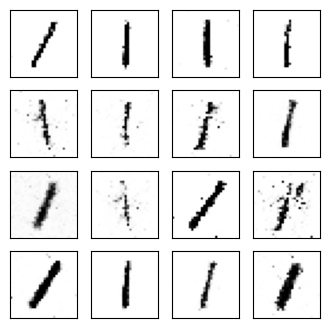

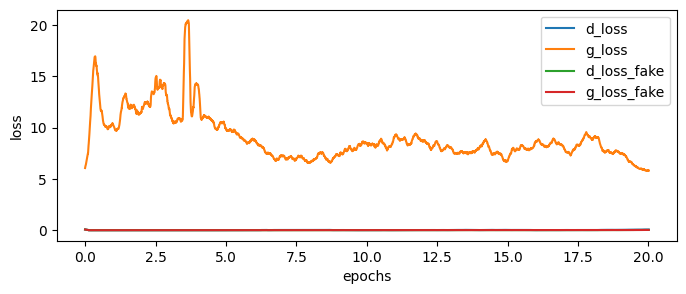

Epoch [21/200], Step[100/469], d_loss: 0.0418, d_loss_fake: 0.0394, g_loss: 5.4952, g_loss_fake: 0.0408, D(x): 1.00, D(G(z)): 0.03
Epoch [21/200], Step[200/469], d_loss: 0.0420, d_loss_fake: 0.0265, g_loss: 4.8128, g_loss_fake: 0.0219, D(x): 0.99, D(G(z)): 0.02
Epoch [21/200], Step[300/469], d_loss: 0.1149, d_loss_fake: 0.0433, g_loss: 4.4974, g_loss_fake: 0.0323, D(x): 0.97, D(G(z)): 0.04
Epoch [21/200], Step[400/469], d_loss: 0.0813, d_loss_fake: 0.0381, g_loss: 4.2499, g_loss_fake: 0.0316, D(x): 0.98, D(G(z)): 0.04
Epoch [22/200], Step[100/469], d_loss: 0.1245, d_loss_fake: 0.0553, g_loss: 3.9025, g_loss_fake: 0.0426, D(x): 0.97, D(G(z)): 0.05
Epoch [22/200], Step[200/469], d_loss: 0.1260, d_loss_fake: 0.0327, g_loss: 4.0261, g_loss_fake: 0.0327, D(x): 0.95, D(G(z)): 0.03
Epoch [22/200], Step[300/469], d_loss: 0.0893, d_loss_fake: 0.0681, g_loss: 4.5961, g_loss_fake: 0.0558, D(x): 0.98, D(G(z)): 0.05
Epoch [22/200], Step[400/469], d_loss: 0.1804, d_loss_fake: 0.0898, g_loss: 4.3504,

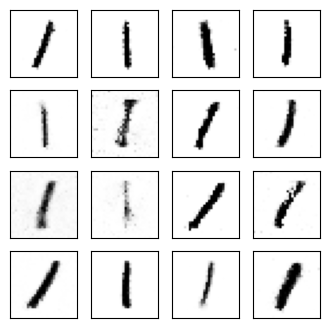

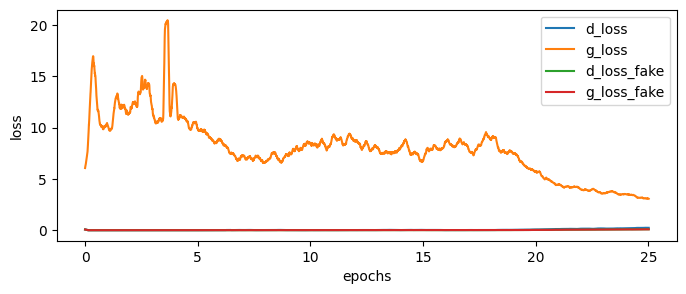

Epoch [26/200], Step[100/469], d_loss: 0.2480, d_loss_fake: 0.0891, g_loss: 2.9115, g_loss_fake: 0.1010, D(x): 0.93, D(G(z)): 0.08
Epoch [26/200], Step[200/469], d_loss: 0.2287, d_loss_fake: 0.0906, g_loss: 3.1927, g_loss_fake: 0.0856, D(x): 0.94, D(G(z)): 0.08
Epoch [26/200], Step[300/469], d_loss: 0.1673, d_loss_fake: 0.0647, g_loss: 3.7612, g_loss_fake: 0.0499, D(x): 0.95, D(G(z)): 0.06
Epoch [26/200], Step[400/469], d_loss: 0.2778, d_loss_fake: 0.1147, g_loss: 3.3314, g_loss_fake: 0.0773, D(x): 0.93, D(G(z)): 0.09
Epoch [27/200], Step[100/469], d_loss: 0.3076, d_loss_fake: 0.0883, g_loss: 2.7231, g_loss_fake: 0.1050, D(x): 0.91, D(G(z)): 0.08
Epoch [27/200], Step[200/469], d_loss: 0.3735, d_loss_fake: 0.1746, g_loss: 2.4917, g_loss_fake: 0.1187, D(x): 0.91, D(G(z)): 0.10
Epoch [27/200], Step[300/469], d_loss: 0.1306, d_loss_fake: 0.0428, g_loss: 3.5160, g_loss_fake: 0.0484, D(x): 0.97, D(G(z)): 0.04
Epoch [27/200], Step[400/469], d_loss: 0.2147, d_loss_fake: 0.0774, g_loss: 2.9349,

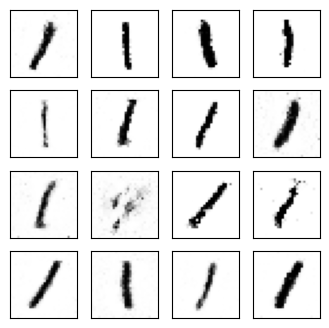

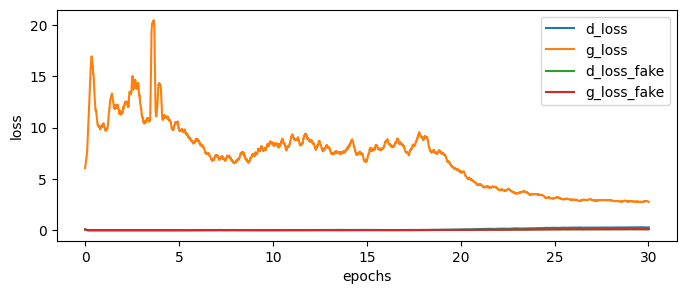

Epoch [31/200], Step[100/469], d_loss: 0.2685, d_loss_fake: 0.0780, g_loss: 3.0180, g_loss_fake: 0.0743, D(x): 0.92, D(G(z)): 0.07
Epoch [31/200], Step[200/469], d_loss: 0.3512, d_loss_fake: 0.1188, g_loss: 2.5818, g_loss_fake: 0.1082, D(x): 0.89, D(G(z)): 0.11
Epoch [31/200], Step[300/469], d_loss: 0.3020, d_loss_fake: 0.1121, g_loss: 2.9952, g_loss_fake: 0.0707, D(x): 0.91, D(G(z)): 0.10
Epoch [31/200], Step[400/469], d_loss: 0.3490, d_loss_fake: 0.0776, g_loss: 2.7823, g_loss_fake: 0.0803, D(x): 0.89, D(G(z)): 0.07
Epoch [32/200], Step[100/469], d_loss: 0.4005, d_loss_fake: 0.1310, g_loss: 2.4578, g_loss_fake: 0.1180, D(x): 0.89, D(G(z)): 0.11
Epoch [32/200], Step[200/469], d_loss: 0.1693, d_loss_fake: 0.0525, g_loss: 3.5669, g_loss_fake: 0.0549, D(x): 0.95, D(G(z)): 0.05
Epoch [32/200], Step[300/469], d_loss: 0.1826, d_loss_fake: 0.0608, g_loss: 3.1546, g_loss_fake: 0.0589, D(x): 0.95, D(G(z)): 0.06
Epoch [32/200], Step[400/469], d_loss: 0.3481, d_loss_fake: 0.1540, g_loss: 2.4713,

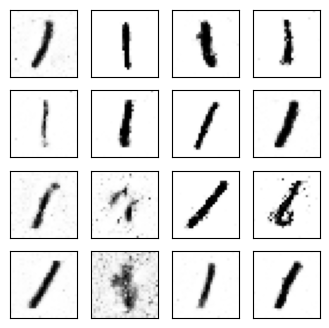

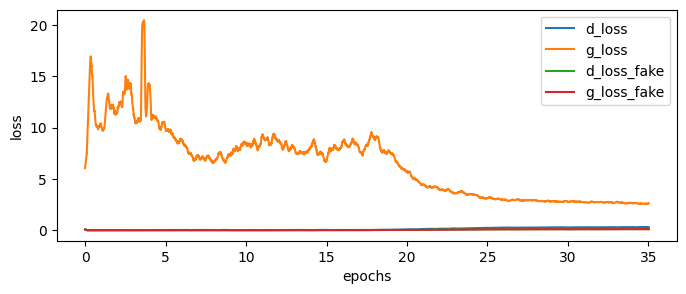

Epoch [36/200], Step[100/469], d_loss: 0.4127, d_loss_fake: 0.1521, g_loss: 2.0952, g_loss_fake: 0.1562, D(x): 0.87, D(G(z)): 0.14
Epoch [36/200], Step[200/469], d_loss: 0.3057, d_loss_fake: 0.1123, g_loss: 2.5489, g_loss_fake: 0.0999, D(x): 0.91, D(G(z)): 0.10
Epoch [36/200], Step[300/469], d_loss: 0.3510, d_loss_fake: 0.1059, g_loss: 2.3128, g_loss_fake: 0.1531, D(x): 0.89, D(G(z)): 0.10
Epoch [36/200], Step[400/469], d_loss: 0.2669, d_loss_fake: 0.1271, g_loss: 2.5225, g_loss_fake: 0.1388, D(x): 0.93, D(G(z)): 0.11
Epoch [37/200], Step[100/469], d_loss: 0.3341, d_loss_fake: 0.1091, g_loss: 2.5678, g_loss_fake: 0.1032, D(x): 0.91, D(G(z)): 0.10
Epoch [37/200], Step[200/469], d_loss: 0.3651, d_loss_fake: 0.1213, g_loss: 2.4507, g_loss_fake: 0.1032, D(x): 0.89, D(G(z)): 0.11
Epoch [37/200], Step[300/469], d_loss: 0.4385, d_loss_fake: 0.1341, g_loss: 2.1524, g_loss_fake: 0.1480, D(x): 0.87, D(G(z)): 0.12
Epoch [37/200], Step[400/469], d_loss: 0.4177, d_loss_fake: 0.1725, g_loss: 2.2356,

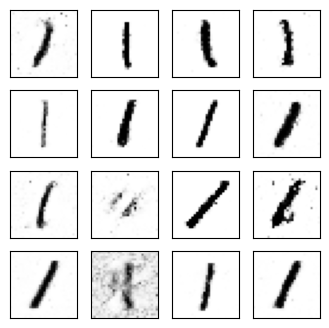

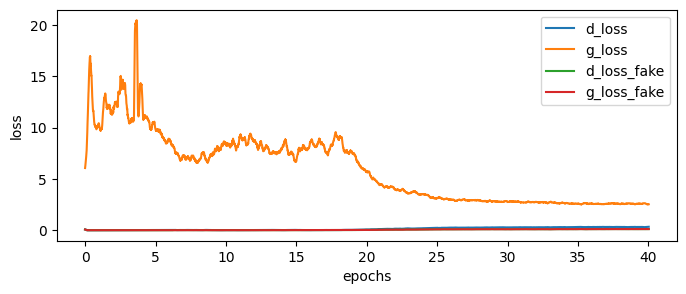

Epoch [41/200], Step[100/469], d_loss: 0.2994, d_loss_fake: 0.0839, g_loss: 2.5608, g_loss_fake: 0.0969, D(x): 0.91, D(G(z)): 0.08
Epoch [41/200], Step[200/469], d_loss: 0.3341, d_loss_fake: 0.1148, g_loss: 2.4457, g_loss_fake: 0.1031, D(x): 0.90, D(G(z)): 0.10
Epoch [41/200], Step[300/469], d_loss: 0.3668, d_loss_fake: 0.1397, g_loss: 2.2736, g_loss_fake: 0.1644, D(x): 0.90, D(G(z)): 0.12
Epoch [41/200], Step[400/469], d_loss: 0.3679, d_loss_fake: 0.1699, g_loss: 2.4254, g_loss_fake: 0.1206, D(x): 0.91, D(G(z)): 0.13
Epoch [42/200], Step[100/469], d_loss: 0.2946, d_loss_fake: 0.0880, g_loss: 2.7550, g_loss_fake: 0.0844, D(x): 0.92, D(G(z)): 0.08
Epoch [42/200], Step[200/469], d_loss: 0.2716, d_loss_fake: 0.0832, g_loss: 2.5791, g_loss_fake: 0.1185, D(x): 0.93, D(G(z)): 0.08
Epoch [42/200], Step[300/469], d_loss: 0.3109, d_loss_fake: 0.1094, g_loss: 2.4479, g_loss_fake: 0.1020, D(x): 0.91, D(G(z)): 0.10
Epoch [42/200], Step[400/469], d_loss: 0.4259, d_loss_fake: 0.1479, g_loss: 2.1631,

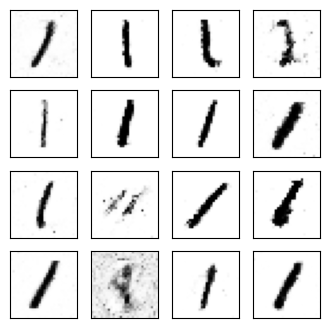

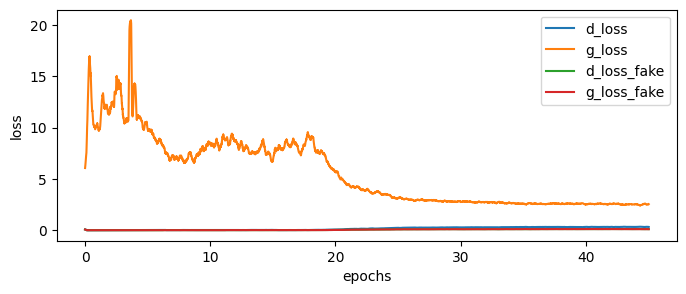

Epoch [46/200], Step[100/469], d_loss: 0.3834, d_loss_fake: 0.1246, g_loss: 2.2759, g_loss_fake: 0.1224, D(x): 0.88, D(G(z)): 0.12
Epoch [46/200], Step[200/469], d_loss: 0.1988, d_loss_fake: 0.0713, g_loss: 2.8353, g_loss_fake: 0.0714, D(x): 0.95, D(G(z)): 0.07
Epoch [46/200], Step[300/469], d_loss: 0.2194, d_loss_fake: 0.0806, g_loss: 2.8723, g_loss_fake: 0.0711, D(x): 0.94, D(G(z)): 0.08
Epoch [46/200], Step[400/469], d_loss: 0.2907, d_loss_fake: 0.0852, g_loss: 2.6850, g_loss_fake: 0.0869, D(x): 0.91, D(G(z)): 0.08
Epoch [47/200], Step[100/469], d_loss: 0.3875, d_loss_fake: 0.1362, g_loss: 2.4320, g_loss_fake: 0.1252, D(x): 0.90, D(G(z)): 0.11
Epoch [47/200], Step[200/469], d_loss: 0.4062, d_loss_fake: 0.1668, g_loss: 2.0816, g_loss_fake: 0.1712, D(x): 0.88, D(G(z)): 0.14
Epoch [47/200], Step[300/469], d_loss: 0.3576, d_loss_fake: 0.1236, g_loss: 2.3086, g_loss_fake: 0.1254, D(x): 0.90, D(G(z)): 0.11
Epoch [47/200], Step[400/469], d_loss: 0.3447, d_loss_fake: 0.1079, g_loss: 2.4933,

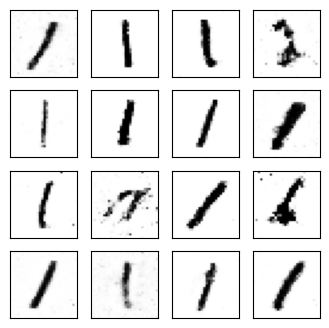

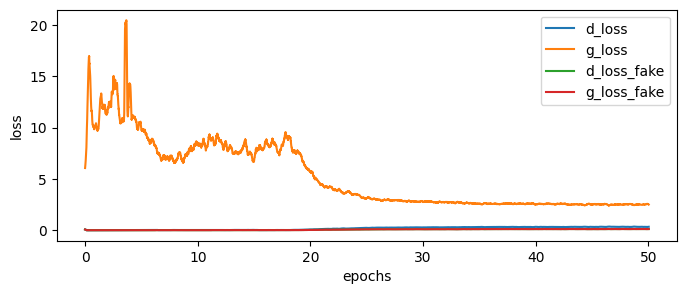

Epoch [51/200], Step[100/469], d_loss: 0.4440, d_loss_fake: 0.1664, g_loss: 2.3439, g_loss_fake: 0.1214, D(x): 0.87, D(G(z)): 0.12
Epoch [51/200], Step[200/469], d_loss: 0.3886, d_loss_fake: 0.1199, g_loss: 2.6410, g_loss_fake: 0.0941, D(x): 0.89, D(G(z)): 0.10
Epoch [51/200], Step[300/469], d_loss: 0.3501, d_loss_fake: 0.1300, g_loss: 2.5074, g_loss_fake: 0.1219, D(x): 0.90, D(G(z)): 0.10
Epoch [51/200], Step[400/469], d_loss: 0.3353, d_loss_fake: 0.0887, g_loss: 2.6851, g_loss_fake: 0.1010, D(x): 0.90, D(G(z)): 0.08
Epoch [52/200], Step[100/469], d_loss: 0.3161, d_loss_fake: 0.0808, g_loss: 2.7187, g_loss_fake: 0.0773, D(x): 0.91, D(G(z)): 0.08
Epoch [52/200], Step[200/469], d_loss: 0.2856, d_loss_fake: 0.0841, g_loss: 2.5420, g_loss_fake: 0.0971, D(x): 0.91, D(G(z)): 0.08
Epoch [52/200], Step[300/469], d_loss: 0.2323, d_loss_fake: 0.0791, g_loss: 2.8290, g_loss_fake: 0.0716, D(x): 0.93, D(G(z)): 0.08
Epoch [52/200], Step[400/469], d_loss: 0.3643, d_loss_fake: 0.0906, g_loss: 2.4872,

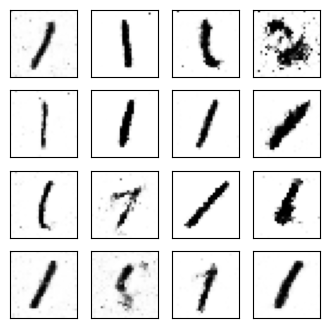

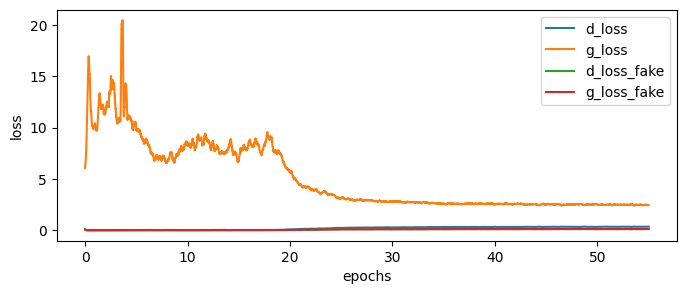

Epoch [56/200], Step[100/469], d_loss: 0.3482, d_loss_fake: 0.1286, g_loss: 2.5419, g_loss_fake: 0.1009, D(x): 0.91, D(G(z)): 0.10
Epoch [56/200], Step[200/469], d_loss: 0.4587, d_loss_fake: 0.2252, g_loss: 2.0559, g_loss_fake: 0.2389, D(x): 0.89, D(G(z)): 0.15
Epoch [56/200], Step[300/469], d_loss: 0.4554, d_loss_fake: 0.2066, g_loss: 2.2165, g_loss_fake: 0.1684, D(x): 0.89, D(G(z)): 0.12
Epoch [56/200], Step[400/469], d_loss: 0.3269, d_loss_fake: 0.1029, g_loss: 2.4246, g_loss_fake: 0.2079, D(x): 0.91, D(G(z)): 0.09
Epoch [57/200], Step[100/469], d_loss: 0.3766, d_loss_fake: 0.1570, g_loss: 2.3595, g_loss_fake: 0.1224, D(x): 0.89, D(G(z)): 0.12
Epoch [57/200], Step[200/469], d_loss: 0.3065, d_loss_fake: 0.1249, g_loss: 2.7339, g_loss_fake: 0.0813, D(x): 0.92, D(G(z)): 0.09
Epoch [57/200], Step[300/469], d_loss: 0.3492, d_loss_fake: 0.1303, g_loss: 2.4634, g_loss_fake: 0.1131, D(x): 0.89, D(G(z)): 0.11
Epoch [57/200], Step[400/469], d_loss: 0.5482, d_loss_fake: 0.1199, g_loss: 2.2557,

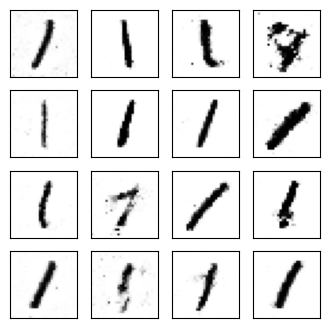

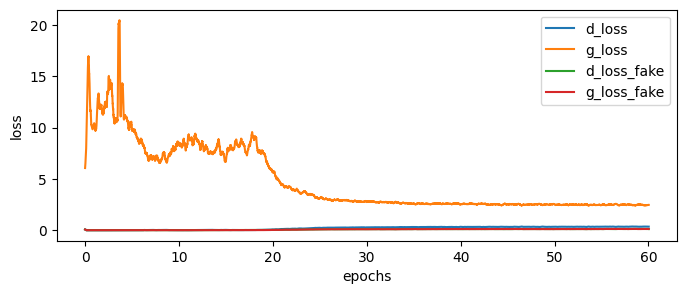

Epoch [61/200], Step[100/469], d_loss: 0.3687, d_loss_fake: 0.1169, g_loss: 2.3932, g_loss_fake: 0.1322, D(x): 0.89, D(G(z)): 0.11
Epoch [61/200], Step[200/469], d_loss: 0.3125, d_loss_fake: 0.1302, g_loss: 2.2685, g_loss_fake: 0.1454, D(x): 0.92, D(G(z)): 0.11
Epoch [61/200], Step[300/469], d_loss: 0.3759, d_loss_fake: 0.1484, g_loss: 2.5436, g_loss_fake: 0.1044, D(x): 0.89, D(G(z)): 0.11
Epoch [61/200], Step[400/469], d_loss: 0.3001, d_loss_fake: 0.1110, g_loss: 2.4204, g_loss_fake: 0.1161, D(x): 0.91, D(G(z)): 0.10
Epoch [62/200], Step[100/469], d_loss: 0.3467, d_loss_fake: 0.1186, g_loss: 2.5270, g_loss_fake: 0.1065, D(x): 0.90, D(G(z)): 0.10
Epoch [62/200], Step[200/469], d_loss: 0.2640, d_loss_fake: 0.0951, g_loss: 2.6653, g_loss_fake: 0.0933, D(x): 0.93, D(G(z)): 0.09
Epoch [62/200], Step[300/469], d_loss: 0.3064, d_loss_fake: 0.1262, g_loss: 2.6682, g_loss_fake: 0.1538, D(x): 0.93, D(G(z)): 0.11
Epoch [62/200], Step[400/469], d_loss: 0.3660, d_loss_fake: 0.1319, g_loss: 2.2413,

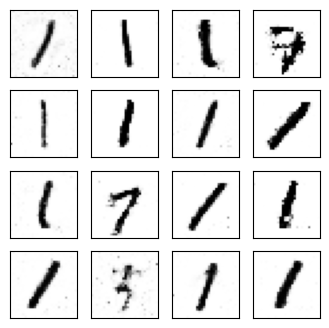

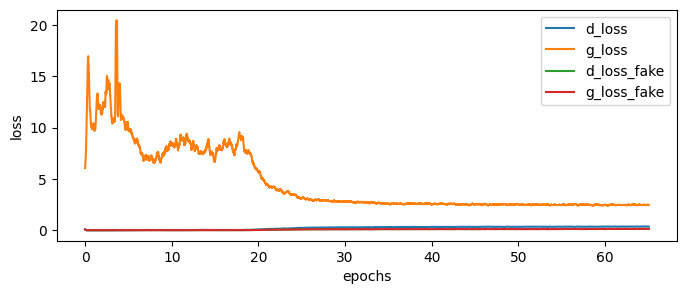

Epoch [66/200], Step[100/469], d_loss: 0.4513, d_loss_fake: 0.1238, g_loss: 2.2258, g_loss_fake: 0.1324, D(x): 0.86, D(G(z)): 0.11
Epoch [66/200], Step[200/469], d_loss: 0.3354, d_loss_fake: 0.1152, g_loss: 2.6982, g_loss_fake: 0.1297, D(x): 0.91, D(G(z)): 0.09
Epoch [66/200], Step[300/469], d_loss: 0.2774, d_loss_fake: 0.0876, g_loss: 2.7571, g_loss_fake: 0.1789, D(x): 0.92, D(G(z)): 0.08
Epoch [66/200], Step[400/469], d_loss: 0.3959, d_loss_fake: 0.1283, g_loss: 2.2560, g_loss_fake: 0.1582, D(x): 0.89, D(G(z)): 0.12
Epoch [67/200], Step[100/469], d_loss: 0.3756, d_loss_fake: 0.1330, g_loss: 2.4408, g_loss_fake: 0.1192, D(x): 0.89, D(G(z)): 0.12
Epoch [67/200], Step[200/469], d_loss: 0.2856, d_loss_fake: 0.0998, g_loss: 2.5901, g_loss_fake: 0.0958, D(x): 0.92, D(G(z)): 0.08
Epoch [67/200], Step[300/469], d_loss: 0.2570, d_loss_fake: 0.0978, g_loss: 2.5102, g_loss_fake: 0.1164, D(x): 0.93, D(G(z)): 0.09
Epoch [67/200], Step[400/469], d_loss: 0.3719, d_loss_fake: 0.1501, g_loss: 2.6655,

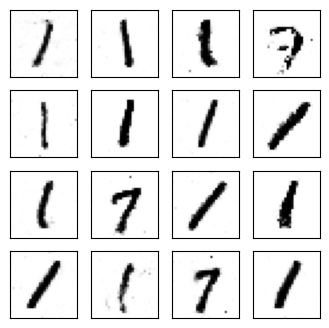

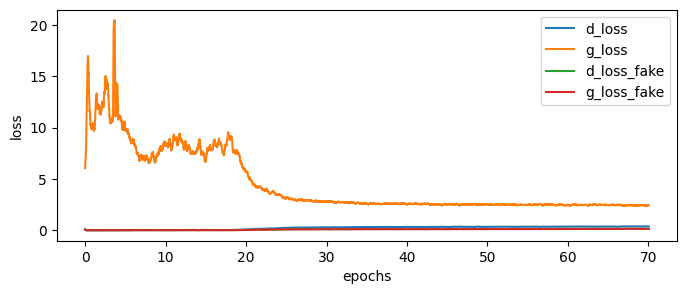

Epoch [71/200], Step[100/469], d_loss: 0.4464, d_loss_fake: 0.1858, g_loss: 2.1725, g_loss_fake: 0.1471, D(x): 0.88, D(G(z)): 0.14
Epoch [71/200], Step[200/469], d_loss: 0.4309, d_loss_fake: 0.1444, g_loss: 2.3471, g_loss_fake: 0.1244, D(x): 0.87, D(G(z)): 0.13
Epoch [71/200], Step[300/469], d_loss: 0.3475, d_loss_fake: 0.1478, g_loss: 2.6551, g_loss_fake: 0.0990, D(x): 0.90, D(G(z)): 0.11
Epoch [71/200], Step[400/469], d_loss: 0.3070, d_loss_fake: 0.1140, g_loss: 2.7119, g_loss_fake: 0.1187, D(x): 0.93, D(G(z)): 0.09
Epoch [72/200], Step[100/469], d_loss: 0.5208, d_loss_fake: 0.2292, g_loss: 2.0888, g_loss_fake: 0.1720, D(x): 0.86, D(G(z)): 0.18
Epoch [72/200], Step[200/469], d_loss: 0.3498, d_loss_fake: 0.1625, g_loss: 2.5109, g_loss_fake: 0.1294, D(x): 0.92, D(G(z)): 0.11
Epoch [72/200], Step[300/469], d_loss: 0.4047, d_loss_fake: 0.1717, g_loss: 2.3558, g_loss_fake: 0.1225, D(x): 0.90, D(G(z)): 0.13
Epoch [72/200], Step[400/469], d_loss: 0.4147, d_loss_fake: 0.1316, g_loss: 2.5156,

In [18]:
##################
### Problem 2: Ablation study 1, 2, and 3
##################
# set number of epochs and initialize figure counter

# Ablation 3: Modify the training loop to update the discriminator 10 times for every 1 update of the generator.

dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

num_epochs = 200
d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

# **2. Conditional GAN**

In [ ]:
num_epochs = 500
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = True

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)